## Load pre-processed adata and impute highly variable genes using MAGIC

In [1]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from pathlib import Path

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

In [2]:
# load file path from ocean
adata_infile = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/female_sc_processed.h5ad'


In [ ]:
# transfer the file to the scratch space
!rsync -aP $adata_infile /dev/shm/

In [4]:
adata = sc.read_h5ad(os.path.join('/dev/shm/', os.path.basename(adata_infile)))

In [ ]:
adata

In [ ]:
print(adata.var['highly_variable'])
print(adata.var.highly_variable.sum())


#### Female donor annotation

In [ ]:
sc.pl.umap(adata, color=['leiden', 'dpt_pseudotime'], legend_loc='on data')

In [ ]:
sc.pl.embedding(adata, basis='pca', color=['leiden'], legend_loc='on data')

In [ ]:
# pre imputation expression of 6 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    layer="counts",
    color=["BATF","IRF8","SPIB","BCL6","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()

#### Impute only highly variable genes by using diffusion in the pca space of cells to get new nearest neighbors

In [2]:
import palantir

In [10]:
TFs_of_importance = ["BATF","IRF8","SPIB","IRF4","PRDM1"]
marker_list = ["IL10", "AICDA", "IL4R", "FCER2", "BCL6", "JUN", "CD69", "JCHAIN", "CD27", "CD38", "XBP1", "MZB1", "MKI67"]
TF_perturb_list = ["BATF3","EGR1","FOS","IKZF1","IRF1","JUNB","JUND","MEF2A","MEF2C","MYB","NFATC1","NFATC2","NFIL3","NFKB1","NFKB2","PAX5","RUNX1","SP3","SPI1","STAT1","STAT5A","TCF12","VDR","XBP1","ZBTB7A"]

# subset the anndata to only include the genes of interest
adata = adata[:, adata.var.highly_variable]

In [ ]:
# check if new adata has var names of interest from the TFs_of_importance list
print(adata.var.highly_variable[TFs_of_importance])
# print how many true values are in the highly_variable column
print(adata.var.highly_variable.sum())
adata


#### Run diffusion maps to get cell-cell similarities

In [ ]:
palantir.utils.run_diffusion_maps(adata,n_components=10) #n_components, select from the plot above, knn = 30 by default for graph construction
adata


#### Run imputation 

In [4]:
palantir.utils.run_magic_imputation(adata)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.20652576,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.13818675, ..., 0.        , 0.15463438,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13459533, 0.        , 0.27273171, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05054533, 0.        ,
        0.        ]])

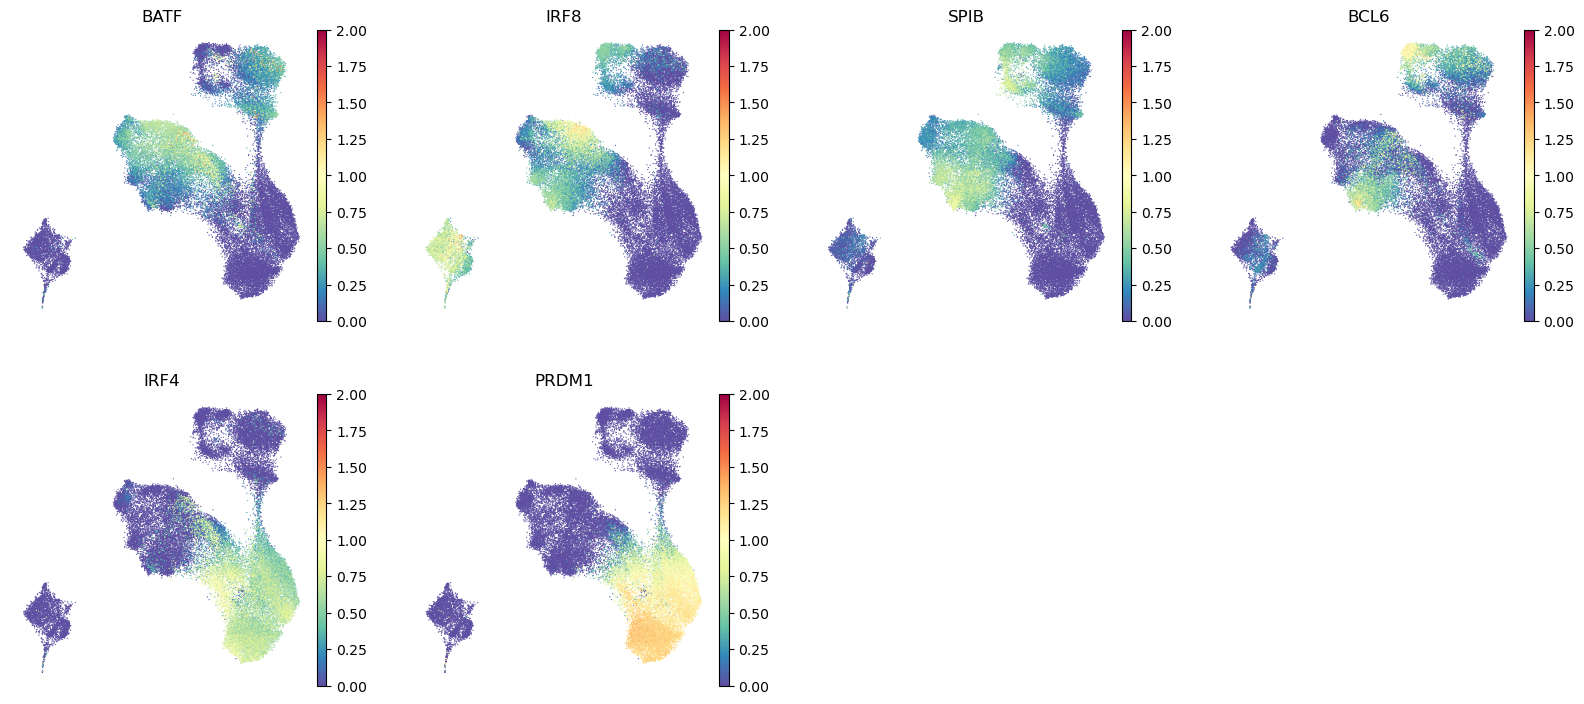

In [5]:
# plot post imputation expression of 5 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["BATF","IRF8","SPIB","BCL6","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()


In [6]:
# save the imputed adata
adata.write_h5ad("/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/multiome_rna_imputed.h5ad")



#### Plot histogram of counts per gene for the imputed data layer to compare with the original data layer

In [30]:
adata = sc.read_h5ad("/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/multiome_rna_imputed.h5ad")

In [ ]:
plt.hist(adata.X.sum(axis=0))
#label the axes
plt.xlabel('Scaled expression per gene')
plt.ylabel('Frequency')
plt.show()

In [ ]:
adata.X = adata.layers['counts']
plt.hist(adata.X.sum(axis=0))
#label the axes
plt.xlabel('Counts per gene')
plt.ylabel('Frequency')
plt.show()


In [ ]:
adata.X = adata.layers['MAGIC_imputed_data']
plt.hist(adata.X.sum(axis=0))
#label the axes
plt.xlabel('Post imputation expression per gene')
plt.ylabel('Frequency')
plt.show()


# Filter day 0,1 cells for stream input

In [7]:
adata.obs['leiden'].cat.categories

Index(['PB-1', 'GC-1', 'PB-2', 'earlyPB', 'ActB-1', 'ActB-3', 'Naive',
       'ActB-2', 'GC-2'],
      dtype='object')

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


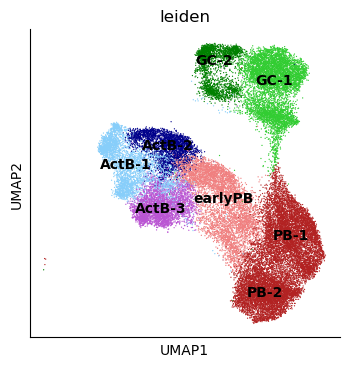

In [8]:
# subset the anndata to only include the cells that are in the sub_cell_type categories of interest
adata=adata[adata.obs['leiden'].isin(['PB-1', 'GC-1', 'PB-2', 'earlyPB', 'ActB-1', 'ActB-3',
       'ActB-2', 'GC-2'])]
sc.pl.umap(adata,color=['leiden'],legend_loc='on data')


In [9]:
# save the anndata
adata.write('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_input_filtered_cells.h5ad')
